# Research Question 2: Can Google Trends data predict whether trading volume will be high next week?

To construct a predictive modeling dataset for RQ2, we begin by downloading raw daily trading volume data for 19 Taiwan-listed tickers using the yfinance API. This data is aggregated to weekly frequency (Monday to Sunday) and summed across all tickers to create a composite measure of retail trading activity, referred to as Total_Volume. We then normalize this series using z-score scaling to form the prediction target, Total_Volume_norm.

Next, we load the attention index dataset, which contains weekly Google Trends-based indicators for six investment themes. These are merged with the normalized total volume based on aligned weekly dates. To ensure that our model uses only past information to predict future outcomes, we lag each attention index by one week. The target variable is also shifted by one week to represent the volume in the week following the attention data. After dropping rows with missing values caused by shifting, we obtain a clean model-ready DataFrame (df_model) where each row represents a forecasting instance: last week's attention indexes are used to predict this week's market-wide trading volume.

#### Code

In [1]:
import pandas as pd
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    mean_squared_error,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.metrics import (
    mean_squared_error,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import numpy as np
import matplotlib.pyplot as plt
import os

#### Code for Creating the Weekly Voulume & Merging it with Attention Indexes

In [2]:
import pandas as pd

# Define tickers
tickers = [
    '0050.TW', '006208.TW', '00878.TW', '00713.TW',
    '2330.TW', '2303.TW', '2412.TW', '3008.TW',
    '2881.TW', '2882.TW', '0056.TW', '9917.TW', '1101.TW',
    '2884.TW', '2603.TW', '1301.TW', '2308.TW',
    '3034.TW', '2454.TW'
]

# Set date range
start_date = "2024-01-01"
end_date = "2024-12-31"

# Download volume data
raw_data = yf.download(tickers, start=start_date, end=end_date, progress=False, group_by='ticker')

# Extract volume columns
volume_data = pd.DataFrame()
for ticker in tickers:
    volume_data[ticker] = raw_data[ticker]['Volume']
\
# Resample to weekly volume
weekly_volume = volume_data.resample('W-MON', label='right', closed='right').sum()
weekly_volume.index = weekly_volume.index - pd.Timedelta(days=1)  # shift label back to Monday

# Aggregate and normalize
weekly_volume['Total_Volume'] = weekly_volume.sum(axis=1)
weekly_volume['Total_Volume_norm'] = (weekly_volume['Total_Volume'] - weekly_volume['Total_Volume'].mean()) / weekly_volume['Total_Volume'].std()

# Preview
print(weekly_volume[['Total_Volume', 'Total_Volume_norm']].head())

YF.download() has changed argument auto_adjust default to True
            Total_Volume  Total_Volume_norm
Date                                       
2024-01-07    1675185269          -0.240532
2024-01-14    1137671351          -1.118494
2024-01-21    2369721583           0.893908
2024-01-28    1585930734          -0.386318
2024-02-04    1474699961          -0.568000


In [22]:
attention_df = pd.read_excel("attention_index_data.xlsx", index_col=0, parse_dates=True)

# Merge attention index and total normalized volume
merged_df_pred = attention_df.join(weekly_volume[['Total_Volume_norm']]).dropna()

# Ensure outputs folder exists
os.makedirs("outputs", exist_ok=True)

# Save the merged DataFrame to Excel
merged_df_pred.to_csv("csv/merged_df_pred.csv")

merged_df_pred.head()

# Step 1: Make a copy to avoid modifying original
df = merged_df_pred.copy()

# Step 2: Drop rows with missing values (NaNs)
df = df.dropna()

# Step 4: Preview the final model-ready DataFrame
df.head()

,ETF_Attention_Index,Stock_Attention_Index,Dividend_Attention_Index,Beginner_Attention_Index,Macro_Attention_Index,Tech_Attention_Index,Total_Volume_norm
date,,,,,,,
2024-01-07,-1.216050,-1.367152,-0.199133,-0.899066,0.390401,-0.575975,-0.240532
2024-01-14,-0.116791,-0.582552,0.236205,-0.666854,-0.072779,-0.180896,-1.118494
2024-01-21,-0.433229,-0.582552,-0.121921,-0.173195,-0.007083,-0.180896,0.893908
2024-01-28,-0.119907,-1.067593,-0.194599,-0.563430,-0.396802,-0.685401,-0.386318
2024-02-04,-1.383650,-2.106888,-1.136914,-0.922065,-0.981105,-1.908722,-0.568000


In [4]:
# Initialize a result dictionary
model_results = {}

# Step 1: Shift attention features by 1 week (lag)
attention_cols = [col for col in df.columns if 'Attention_Index' in col]
for col in attention_cols:
    df[f'{col}_lag1'] = df[col].shift(1)

# Step 2: Create prediction target (next week's volume)
target_ticker = 'Total_Volume_norm' 
df['target'] = df[target_ticker].shift(-1)

# Step 3: Drop rows with NaN (due to shifting)
df_model = df[[f'{col}_lag1' for col in attention_cols] + ['target']].dropna()

In [5]:
df_model.head()

,ETF_Attention_Index_lag1,Stock_Attention_Index_lag1,Dividend_Attention_Index_lag1,Beginner_Attention_Index_lag1,Macro_Attention_Index_lag1,Tech_Attention_Index_lag1,target
date,,,,,,,
2024-01-14,-1.216050,-1.367152,-0.199133,-0.899066,0.390401,-0.575975,0.893908
2024-01-21,-0.116791,-0.582552,0.236205,-0.666854,-0.072779,-0.180896,-0.386318
2024-01-28,-0.433229,-0.582552,-0.121921,-0.173195,-0.007083,-0.180896,-0.568000
2024-02-04,-0.119907,-1.067593,-0.194599,-0.563430,-0.396802,-0.685401,-2.976740
2024-02-11,-1.383650,-2.106888,-1.136914,-0.922065,-0.981105,-1.908722,-0.926831


## 4.2.1 Linear Regression Model

To investigate whether Google Trends attention indexes can help forecast short-term trading volume, we build three linear regression models using different configurations of input features. In the **attention-only model**, we use six lagged attention indexes (shifted by one week) to predict normalized total trading volume in the following week. In the **volume-only baseline**, we use only lagged total volume as the sole predictor. Finally, in the **combined model**, we use both lagged attention and lagged volume features.

All models are trained on the first 70% of the weekly data and tested on the remaining 30%, with RMSE (Root Mean Squared Error) used as the evaluation metric.

The **attention-only model** (Figure 4.2.1) achieves an RMSE of **0.99**, suggesting that Google Trends data alone contains moderate predictive information. However, it underestimates several sharp volume surges, indicating limited responsiveness to extreme events.

Surprisingly, the **volume-only baseline** (Figure 4.2.2) performs better, with an RMSE of **0.88**. This suggests that last week’s trading activity alone is a relatively stable predictor of next week’s volume, likely due to strong market autocorrelation.

When combining both attention and volume inputs (Figure 4.2.3), performance worsens with an RMSE of **1.07**. This indicates potential multicollinearity or noise introduced when merging high-dimensional attention signals with endogenous volume features.

As summarized in **Figure 4.2.4**, these results imply that while attention signals are somewhat informative on their own, they do not improve forecasts when added to volume under a linear modeling framework. More flexible models may be needed to capture non-linear interactions and maximize predictive accuracy.

#### Code

In [6]:
# Train/test split and fit regression model

# Step 1: Define X (features) and y (target)
X = df_model.drop(columns='target')
y = df_model['target']

# Step 2: Split data by time (70% train, 30% test)
split_idx = int(len(df_model) * 0.7)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Step 3: Fit linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 4: Make predictions and evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"RMSE on test set: {rmse:.4f}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
model_results['Attention_Only_LR'] = rmse

RMSE on test set: 0.9927


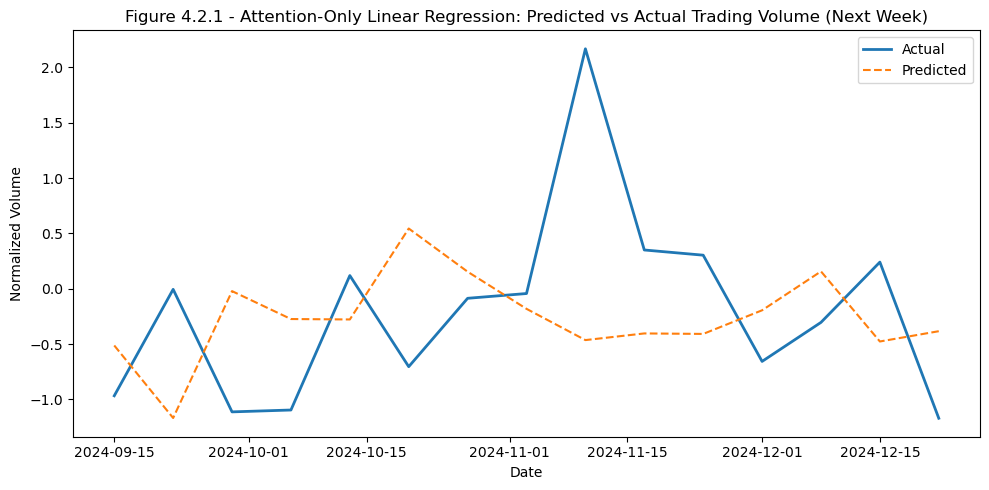

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test.values, label='Actual', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicted', linestyle='--')
plt.title('Figure 4.2.1 - Attention-Only Linear Regression: Predicted vs Actual Trading Volume (Next Week)')
plt.xlabel('Date')
plt.ylabel('Normalized Volume')
plt.legend()
plt.tight_layout()
plt.savefig("plots/4.2.1_attention_lr_pred_vs_actual.png", dpi=300)
plt.show()

In [8]:
# Step 1: Create lagged volume feature (t-1) and target (t)
baseline_df = df[[target_ticker]].copy()
baseline_df['lagged_volume'] = baseline_df[target_ticker].shift(1)
baseline_df['target'] = baseline_df[target_ticker].shift(-1)

# Step 2: Drop missing values
baseline_df = baseline_df.dropna()

# Step 3: Define features and target
X_base = baseline_df[['lagged_volume']]
y_base = baseline_df['target']

# Step 4: Time-based train/test split
split_idx = int(len(baseline_df) * 0.7)
Xb_train, Xb_test = X_base.iloc[:split_idx], X_base.iloc[split_idx:]
yb_train, yb_test = y_base.iloc[:split_idx], y_base.iloc[split_idx:]

# Step 5: Fit linear regression model
baseline_model = LinearRegression()
baseline_model.fit(Xb_train, yb_train)

# Step 6: Predict and evaluate
yb_pred = baseline_model.predict(Xb_test)
baseline_rmse = np.sqrt(mean_squared_error(yb_test, yb_pred))
print(f"Baseline RMSE (Lagged Volume): {baseline_rmse:.4f}")

# Step 7: Save RMSE
model_results['Volume_Only_LR'] = baseline_rmse

Baseline RMSE (Lagged Volume): 0.8766


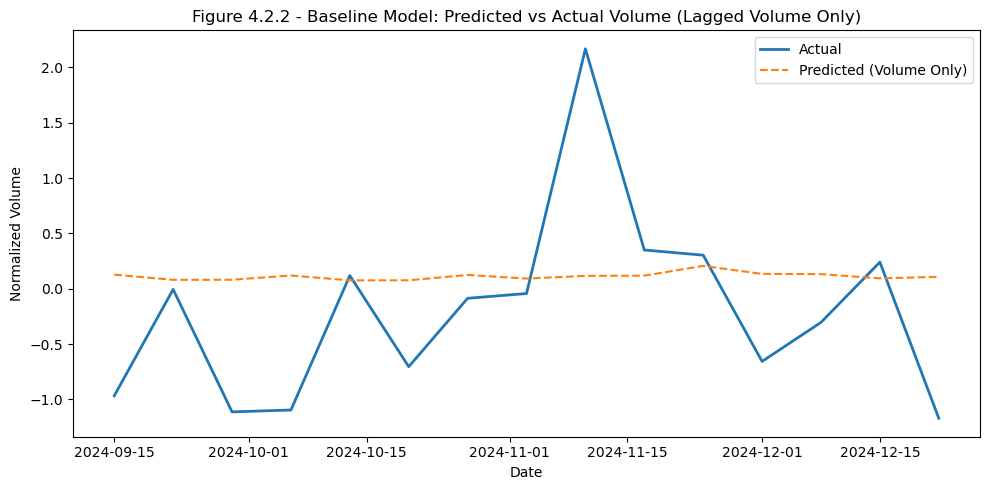

In [15]:
# Ensure output folder exists
os.makedirs("outputs", exist_ok=True)

plt.figure(figsize=(10, 5))
plt.plot(yb_test.index, yb_test.values, label='Actual', linewidth=2)
plt.plot(yb_test.index, yb_pred, label='Predicted (Volume Only)', linestyle='--')
plt.title('Figure 4.2.2 - Baseline Model: Predicted vs Actual Volume (Lagged Volume Only)')
plt.xlabel('Date')
plt.ylabel('Normalized Volume')
plt.legend()
plt.tight_layout()
plt.savefig("plots/4.2.2_volume_baseline_pred_vs_actual.png", dpi=300)
plt.show()

In [10]:
# Step 1: Copy and extend the existing df
df_combined = df.copy()

# Step 2: Create lagged attention features
attention_cols = [col for col in df_combined.columns if 'Attention_Index' in col]
for col in attention_cols:
    df_combined[f'{col}_lag1'] = df_combined[col].shift(1)

# Step 3: Create lagged volume and target
df_combined['lagged_volume'] = df_combined[target_ticker].shift(1)
df_combined['target'] = df_combined[target_ticker].shift(-1)

# Step 4: Select features and drop missing values
combined_features = [f'{col}_lag1' for col in attention_cols] + ['lagged_volume']
df_combined_model = df_combined[combined_features + ['target']].dropna()

# Step 5: Define X and y
X_comb = df_combined_model[combined_features]
y_comb = df_combined_model['target']

# Step 6: Train/test split by time
split_idx = int(len(df_combined_model) * 0.7)
Xc_train, Xc_test = X_comb.iloc[:split_idx], X_comb.iloc[split_idx:]
yc_train, yc_test = y_comb.iloc[:split_idx], y_comb.iloc[split_idx:]

# Step 7: Fit model
combined_model = LinearRegression()
combined_model.fit(Xc_train, yc_train)

# Step 8: Predict and evaluate
yc_pred = combined_model.predict(Xc_test)
combined_rmse = np.sqrt(mean_squared_error(yc_test, yc_pred))
print(f"Combined Model RMSE (Attention + Volume): {combined_rmse:.4f}")

# Step 9: Save RMSE
model_results['Attention+Volume_LR'] = combined_rmse

Combined Model RMSE (Attention + Volume): 1.0749


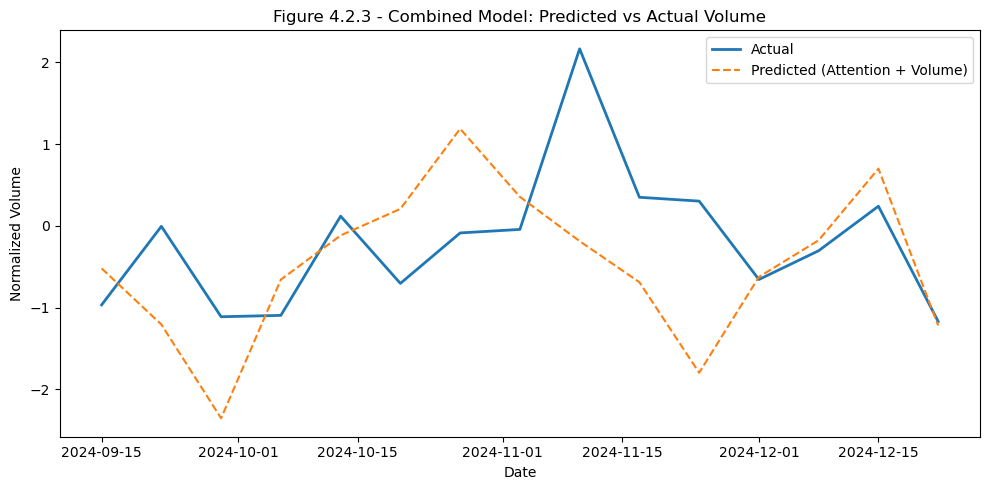

In [16]:
# Ensure output folder exists
os.makedirs("outputs", exist_ok=True)

plt.figure(figsize=(10, 5))
plt.plot(yc_test.index, yc_test.values, label='Actual', linewidth=2)
plt.plot(yc_test.index, yc_pred, label='Predicted (Attention + Volume)', linestyle='--')
plt.title('Figure 4.2.3 - Combined Model: Predicted vs Actual Volume')
plt.xlabel('Date')
plt.ylabel('Normalized Volume')
plt.legend()
plt.tight_layout()
plt.savefig("plots/4.2.3_combined_attention_volume_pred_vs_actual.png", dpi=300)
plt.show()

In [12]:
# Convert results dict to DataFrame
results_df = pd.DataFrame.from_dict(model_results, orient='index', columns=['RMSE'])
results_df = results_df.sort_values(by='RMSE')  # optional: sort from best to worst

# Display
results_df.head()

# Ensure output directory exists
os.makedirs("csv", exist_ok=True)

# Export to CSV
results_df.to_csv("csv/rq2_model_rmse_comparison.csv", index=False)

<Figure size 800x500 with 0 Axes>

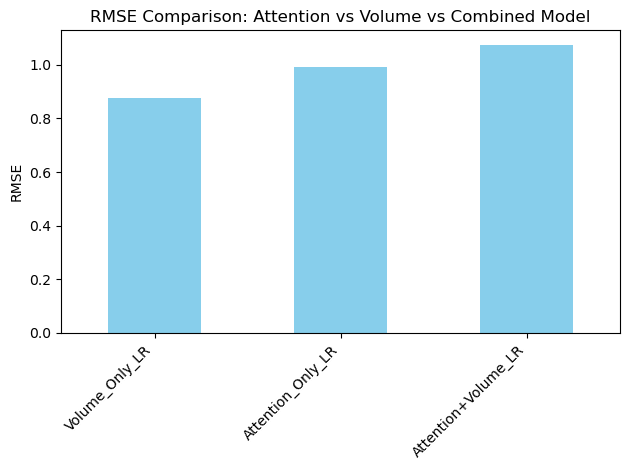

In [13]:
plt.figure(figsize=(8, 5))
results_df.plot(kind='bar', legend=False, color='skyblue')
plt.title("RMSE Comparison: Attention vs Volume vs Combined Model")
plt.ylabel("RMSE")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("plots/4.2.4_model_rmse_bar_chart.png", dpi=300)
plt.show()

## 4.2.2 Logistic Regression Model

To assess whether Google Trends attention data can effectively classify future trading weeks as high or low volume, we implement a series of binary classification models using **logistic regression**. 

We define a high-volume week as one in which the normalized total trading volume (`Total_Volume_norm`) exceeds its historical mean. This yields a binary target variable, `target_class`, where 1 indicates a high-volume week and 0 otherwise.

We evaluate **three different feature sets** to test the predictive value of attention data, lagged volume data, and their combination:

1. **Attention-Only Model**  
   This model uses six lagged attention indexes (each shifted by one week) as input features. It achieves an overall accuracy of **62.5%**, with balanced performance across both classes (precision and recall = 0.73 for low-volume weeks; 0.40 for high-volume weeks).  
   The model offers moderate discriminative ability, identifying many low-volume weeks correctly but struggling with precision and recall on high-volume weeks. This suggests that while attention data carry some directional signals, they are insufficient for robust binary classification.

2. **Volume-Only Model**  
   Using only the lagged total trading volume as input, this model performs poorly, achieving an accuracy of **33.3%**.  
   The model fails to predict any low-volume weeks, with all predictions falling into the high-volume class. This imbalance leads to undefined precision on one class and confirms that volume alone offers limited value for classification tasks, especially under this thresholding scheme.

3. **Combined Model (Attention + Volume)**  
   Integrating all attention features and lagged total volume, this model achieves a slightly lower overall accuracy of **60.0%**, with more balanced but still limited classification power.  
   It achieves a precision of 0.67 for low-volume weeks and 0.33 for high-volume weeks, but both recall and F1-scores remain weak. The performance is slightly worse than the attention-only model, again highlighting that adding volume does not significantly improve classification accuracy and may introduce noise.

Across all three models, the logistic regression classifier shows only **moderate ability** to distinguish high-volume from low-volume weeks. The attention-only model performs best, suggesting that retail attention does contain weak directional signals.  
However, classification accuracy remains close to chance, and the models suffer from imbalanced performance and low recall on high-volume weeks. These findings indicate that while attention-based features carry some predictive value, more **sophisticated classification approaches** or **alternative labeling strategies** may be needed to meaningfully improve binary prediction tasks.

In summary, the results of Section 4.2 offer a nuanced answer to RQ2: Can lagged Google Trends data predict whether trading volume will be high next week? Both regression and classification analyses show that attention-based indicators do carry predictive information, but their standalone power is limited. In linear regression, the attention-only model performs modestly (RMSE = 0.99), while the volume-only baseline surprisingly outperforms it (RMSE = 0.88), and combining both inputs does not yield further improvement (RMSE = 1.07). Similarly, logistic regression shows that attention features enable moderate classification (accuracy = 62.5%), but adding lagged volume does not enhance this further, and volume-only classification performs poorly (accuracy = 33.3%). These findings do not support Hypothesis H2.1, as incorporating attention data does not significantly improve forecasting accuracy over volume-based baselines. Moreover, Hypothesis H2.2 also receives limited support: attention signals may be more useful for identifying low-volume (quieter) weeks than high-volume spikes, but the effect is modest and inconsistent. Overall, while attention data adds some predictive value, more advanced modeling or refined feature engineering is needed to fully leverage its potential in forecasting weekly trading activity.

#### Code

In [17]:
df_model = merged_df_pred.copy()

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Step 1: Create binary classification target
threshold = df_model['Total_Volume_norm'].mean()
df_model['target_class'] = (df_model['Total_Volume_norm'] > threshold).astype(int)

# Step 2: Define features and classification target
X_cls = df_model.drop(columns=['Total_Volume_norm', 'target_class'])  # all attention features
y_cls = df_model['target_class']

# Step 3: Time-based train/test split
split_idx = int(len(df_model) * 0.7)
X_train, X_test = X_cls.iloc[:split_idx], X_cls.iloc[split_idx:]
y_train, y_test = y_cls.iloc[:split_idx], y_cls.iloc[split_idx:]

# Step 4: Fit logistic regression
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)

# Step 5: Predict and evaluate
y_pred = logreg_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")

# Confusion Matrix and Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Optional: Store result in model_results
model_results['Attention_Only_LogReg'] = accuracy


Logistic Regression Accuracy: 0.6250

Confusion Matrix:
[[8 3]
 [3 2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.40      0.40      0.40         5

    accuracy                           0.62        16
   macro avg       0.56      0.56      0.56        16
weighted avg       0.62      0.62      0.62        16



In [19]:
# Step 2: Define features and target
X_vol = df_model[['Total_Volume_norm']].shift(1).dropna()  # lagged volume only
y_vol = df_model['target_class'].shift(-1)                 # match the same target alignment
df_vol = pd.concat([X_vol, y_vol], axis=1).dropna()
X_vol = df_vol[['Total_Volume_norm']]
y_vol = df_vol['target_class']

# Step 3: Time-based split
split_idx = int(len(X_vol) * 0.7)
X_train, X_test = X_vol.iloc[:split_idx], X_vol.iloc[split_idx:]
y_train, y_test = y_vol.iloc[:split_idx], y_vol.iloc[split_idx:]

# Step 4–5: Fit and evaluate
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)
y_pred = logreg_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy (Volume Only): {accuracy:.4f}")

# Confusion Matrix and Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Logistic Regression Accuracy (Volume Only): 0.3333

Confusion Matrix:
[[ 0 10]
 [ 0  5]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        10
         1.0       0.33      1.00      0.50         5

    accuracy                           0.33        15
   macro avg       0.17      0.50      0.25        15
weighted avg       0.11      0.33      0.17        15



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
# Step 2: Define features and target
attention_cols = [col for col in df_model.columns if 'Attention_Index' in col]
X_comb = df_model[attention_cols].copy()
X_comb['lagged_volume'] = df_model['Total_Volume_norm'].shift(1)
y_comb = df_model['target_class'].shift(-1)

# Drop NaN due to lagging
df_comb = pd.concat([X_comb, y_comb], axis=1).dropna()
X_comb = df_comb.drop(columns='target_class')
y_comb = df_comb['target_class']

# Step 3: Train/test split
split_idx = int(len(X_comb) * 0.7)
X_train, X_test = X_comb.iloc[:split_idx], X_comb.iloc[split_idx:]
y_train, y_test = y_comb.iloc[:split_idx], y_comb.iloc[split_idx:]

# Step 4–5: Fit and evaluate
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)
y_pred = logreg_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy (Attention + Volume): {accuracy:.4f}")
# Confusion Matrix and Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Logistic Regression Accuracy (Attention + Volume): 0.6000

Confusion Matrix:
[[8 2]
 [4 1]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.80      0.73        10
         1.0       0.33      0.20      0.25         5

    accuracy                           0.60        15
   macro avg       0.50      0.50      0.49        15
weighted avg       0.56      0.60      0.57        15

